# Setup

In [1]:
# !pip install -qU langchain
# !pip install -qU langchain-google-genai
# !pip install -qU langchain-huggingface
# !pip install -qU langchain-qdrant
# !pip install -qU langchain-community
# !pip install -qU langgraph
# !pip install fastembed
# !pip install datasets
# !pip install -U "fsspec[http]==2024.10.0"

# Code

In this assignment, you will need to set up and use
1. LangSmith to monitor your agent.
2. Use hybrid search to improve your retriever
3. Use a reranker to improve your search result.



## TODO 0: Set up LangSmith

Create a LangSmith account and set up tracing for this assignment. https://www.smith.langchain.com/.

No need to configure, just add your LangSmith API key.

In [2]:
# import os
# from google.colab import userdata

# os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api_key')

from dotenv import load_dotenv
import os
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("gemini_api_key")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")


## Components

We will be using Gemini as our LLM. Feel free to try out others if you want.

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

For our sentence embeddings, we will use [ModernBERT](https://arxiv.org/abs/2412.13663) trained by Alibaba as it is small and performant.

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

model_kwargs = {'trust_remote_code': True}
embeddings = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-modernbert-base",model_kwargs=model_kwargs)

2025-04-07 17:28:39.615090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 17:28:39.622001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744021719.630477   15038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744021719.633044   15038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 17:28:39.641863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Likewise, the reranker is also based on the ModernBERT trained by Alibaba.

In [5]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="Alibaba-NLP/gte-reranker-modernbert-base")

For our dataset, we will be using SQuAD v2 dataset.

In [6]:
import datasets

ds = datasets.load_dataset("rajpurkar/squad_v2", split="validation")

## Indexing

In [7]:
from langchain_core.documents import Document

In [8]:
all_docs = [Document(text) for text in  list(set(ds["context"]))]
print(len(all_docs))

1204


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(all_docs)

print(f"Split wiki abstract into {len(all_splits)} sub-documents.")

Split wiki abstract into 1222 sub-documents.


## TODO 1: Hybrid Search
Embed your documents in a vector database that supports hybrid search. Also set the retrieval mode to hybrid search. Use BM25 as the lexical search.

Hint: read more on `QdrantVectorStore` [here](https://python.langchain.com/api_reference/qdrant/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore). (You can use any vector DB that can do hybrid search)

In [10]:
from langchain_qdrant import QdrantVectorStore, RetrievalMode, FastEmbedSparse
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, SparseVectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="squadv2",
    vectors_config={"dense": VectorParams(size=768, distance=Distance.COSINE)},
    sparse_vectors_config={"sparse": SparseVectorParams()}
)

sprase_embeddings = FastEmbedSparse()

vector_store = QdrantVectorStore(
    client,
    collection_name="squadv2",
    embedding=embeddings,
    sparse_embedding=sprase_embeddings,
    retrieval_mode=RetrievalMode.HYBRID,
    vector_name="dense",
    sparse_vector_name="sparse",
)

document_ids = vector_store.add_documents(documents=all_splits)

In [11]:
print(document_ids[:3])

['d1ce09821a5043a58f2ac7bdedb6a8fb', '07592e19c89c4ab988b3a664272de569', '4ae6f5ee0cda4e55b175eb61246f1b8c']


## TODO 2: Reranking

Create two retrievers.
1. A normal retriever without a reranker. Set the `top_k` to 20.
2. A retriever with a reranker. Set the `top_k` of the reranker to 3.


In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

retriever_vanilla = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 20})

reranker = CrossEncoderReranker(
    model=model,
)

def invoke_reranker(query):
    doc_all = retriever_vanilla.invoke(query)
    reranked = reranker.compress_documents(doc_all, query)
    return reranked[:3]

In [13]:
print(ds[0]["question"], ds[0]["answers"])

In what country is Normandy located? {'text': ['France', 'France', 'France', 'France'], 'answer_start': [159, 159, 159, 159]}


In [14]:
out = retriever_vanilla.invoke(ds[0]["question"])
print(out[0])

page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.' metadata={'start_index': 0, '_id': 'a83349bb2fd74efa84a6369c35d6d29c', '_collection_name': 'squadv2'}


Take a subset of the dataset to evaluate the MRR of the retrievers.

In [15]:
print(ds[0].keys())

dict_keys(['id', 'title', 'context', 'question', 'answers'])


In [16]:
sample = ds.take(1000)

In [17]:
print(sample[0]["id"])

56ddde6b9a695914005b9628


## TODO 3: Retrieval Evaluation

Calculate the MRR of the two retrievers based on the top 3 returned by each retriever.

**For the vanilla retriever (no reranker), take only the top-3 to evaluate the MRR and ignore the rest.**

In [17]:
from tqdm import tqdm
no_rerank, rerank = 0, 0
no_rerank_failures, rerank_failures = 0, 0
for i in tqdm(range(len(sample))):
    all_vanilla = retriever_vanilla.invoke(sample[i]["question"])
    all_rerank = invoke_reranker(sample[i]["question"])
    ch_no, ch_re = 0, 0
    for j in range(3):
        if ch_no == 0 and sample[i]["context"] == all_vanilla[j].page_content:
            no_rerank += 1/(j+1)
            ch_no = 1
        if ch_re == 0 and sample[i]["context"] == all_rerank[j].page_content:
            rerank += 1/(j+1)
            ch_re = 1
    if ch_no == 0:
        no_rerank_failures += 1
    if ch_re == 0:
        rerank_failures += 1

100%|██████████| 1000/1000 [03:08<00:00,  5.30it/s]


In [18]:
print(f"MRR of the retriever without a reranker: {no_rerank / len(sample):.4f}")
print(f"MRR of the retriever with a reranker: {rerank / len(sample):.4f}")

print(f"Percentage of queries with no relevant doc in top 3 (no rerank): {100 * no_rerank_failures / len(sample):.2f}%")
print(f"Percentage of queries with no relevant doc in top 3 (rerank): {100 * rerank_failures / len(sample):.2f}%")

MRR of the retriever without a reranker: 0.7510
MRR of the retriever with a reranker: 0.9237
Percentage of queries with no relevant doc in top 3 (no rerank): 21.90%
Percentage of queries with no relevant doc in top 3 (rerank): 4.50%


## Agentic RAG

Feel free to use the workflow from the demo. However, you will need to modify it slightly to use the retriever with a reranker.

In [21]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langsmith import traceable

graph_builder = StateGraph(MessagesState)

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query from a vector database containing information on student's handbook."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
@traceable
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
@traceable
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

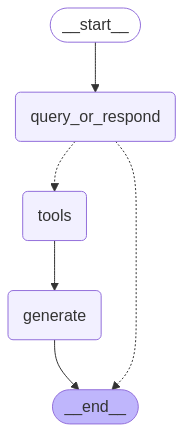

In [22]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [24]:
assert False

AssertionError: 

In [29]:
input_message = "บัตรนิสิตหายต้องทำยังไง"
# input_message = "ข้าวมันไก่"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

บัตรนิสิตหายต้องทำยังไง
================================== Ai Message ==================================

Unfortunately, I don't have specific information on the exact procedure for replacing a lost student ID card. However, here's some general advice on what you should do:

1. **Report the loss:** Immediately report the loss to the appropriate office at your university. This is usually the student affairs office, the registrar's office, or the security department. Reporting it quickly can prevent misuse of your card.
2. **Inquire about replacement:** Ask the office you reported the loss to about the process for getting a replacement card. They will likely tell you what documents you need and if there's a replacement fee.
3. **Gather required documents:** You will probably need some form of identification (like your national ID card or passport) and possibly a student registration document. Check with the

## TODO 4: Usage
Run your agent twice. Once on a message that doesn't need tool-use like "hello" and again for a message that does.

In [30]:
input_message = "hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [31]:
input_message = "How Redbull company started?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How Redbull company started?
================================== Ai Message ==================================
Tool Calls:
  retrieve (efbb9f5f-0959-49d4-8380-51764eaeb474)
 Call ID: efbb9f5f-0959-49d4-8380-51764eaeb474
  Args:
    query: How did Red Bull company start?
================================= Tool Message =================================
Name: retrieve

Source: {'start_index': 0, '_id': 'ab010bada6144a79b8928d2e4b79e099', '_collection_name': 'squadv2'}
Content: Formed in November 1990 by the equal merger of Sky Television and British Satellite Broadcasting, BSkyB became the UK's largest digital subscription television company. Following BSkyB's 2014 acquisition of Sky Italia and a majority 90.04% interest in Sky Deutschland in November 2014, its holding company British Sky Broadcasting Group plc changed its name to Sky plc. The United Kingdom operations also changed the company name from Britis

## TODO 5: Monitor your agent in LangSmith.

If you have set up correctly, you can just visit the LangSmith website and see that your tracings are logged into your LangSmith project.

Capture your screen like this and upload it to MCV.

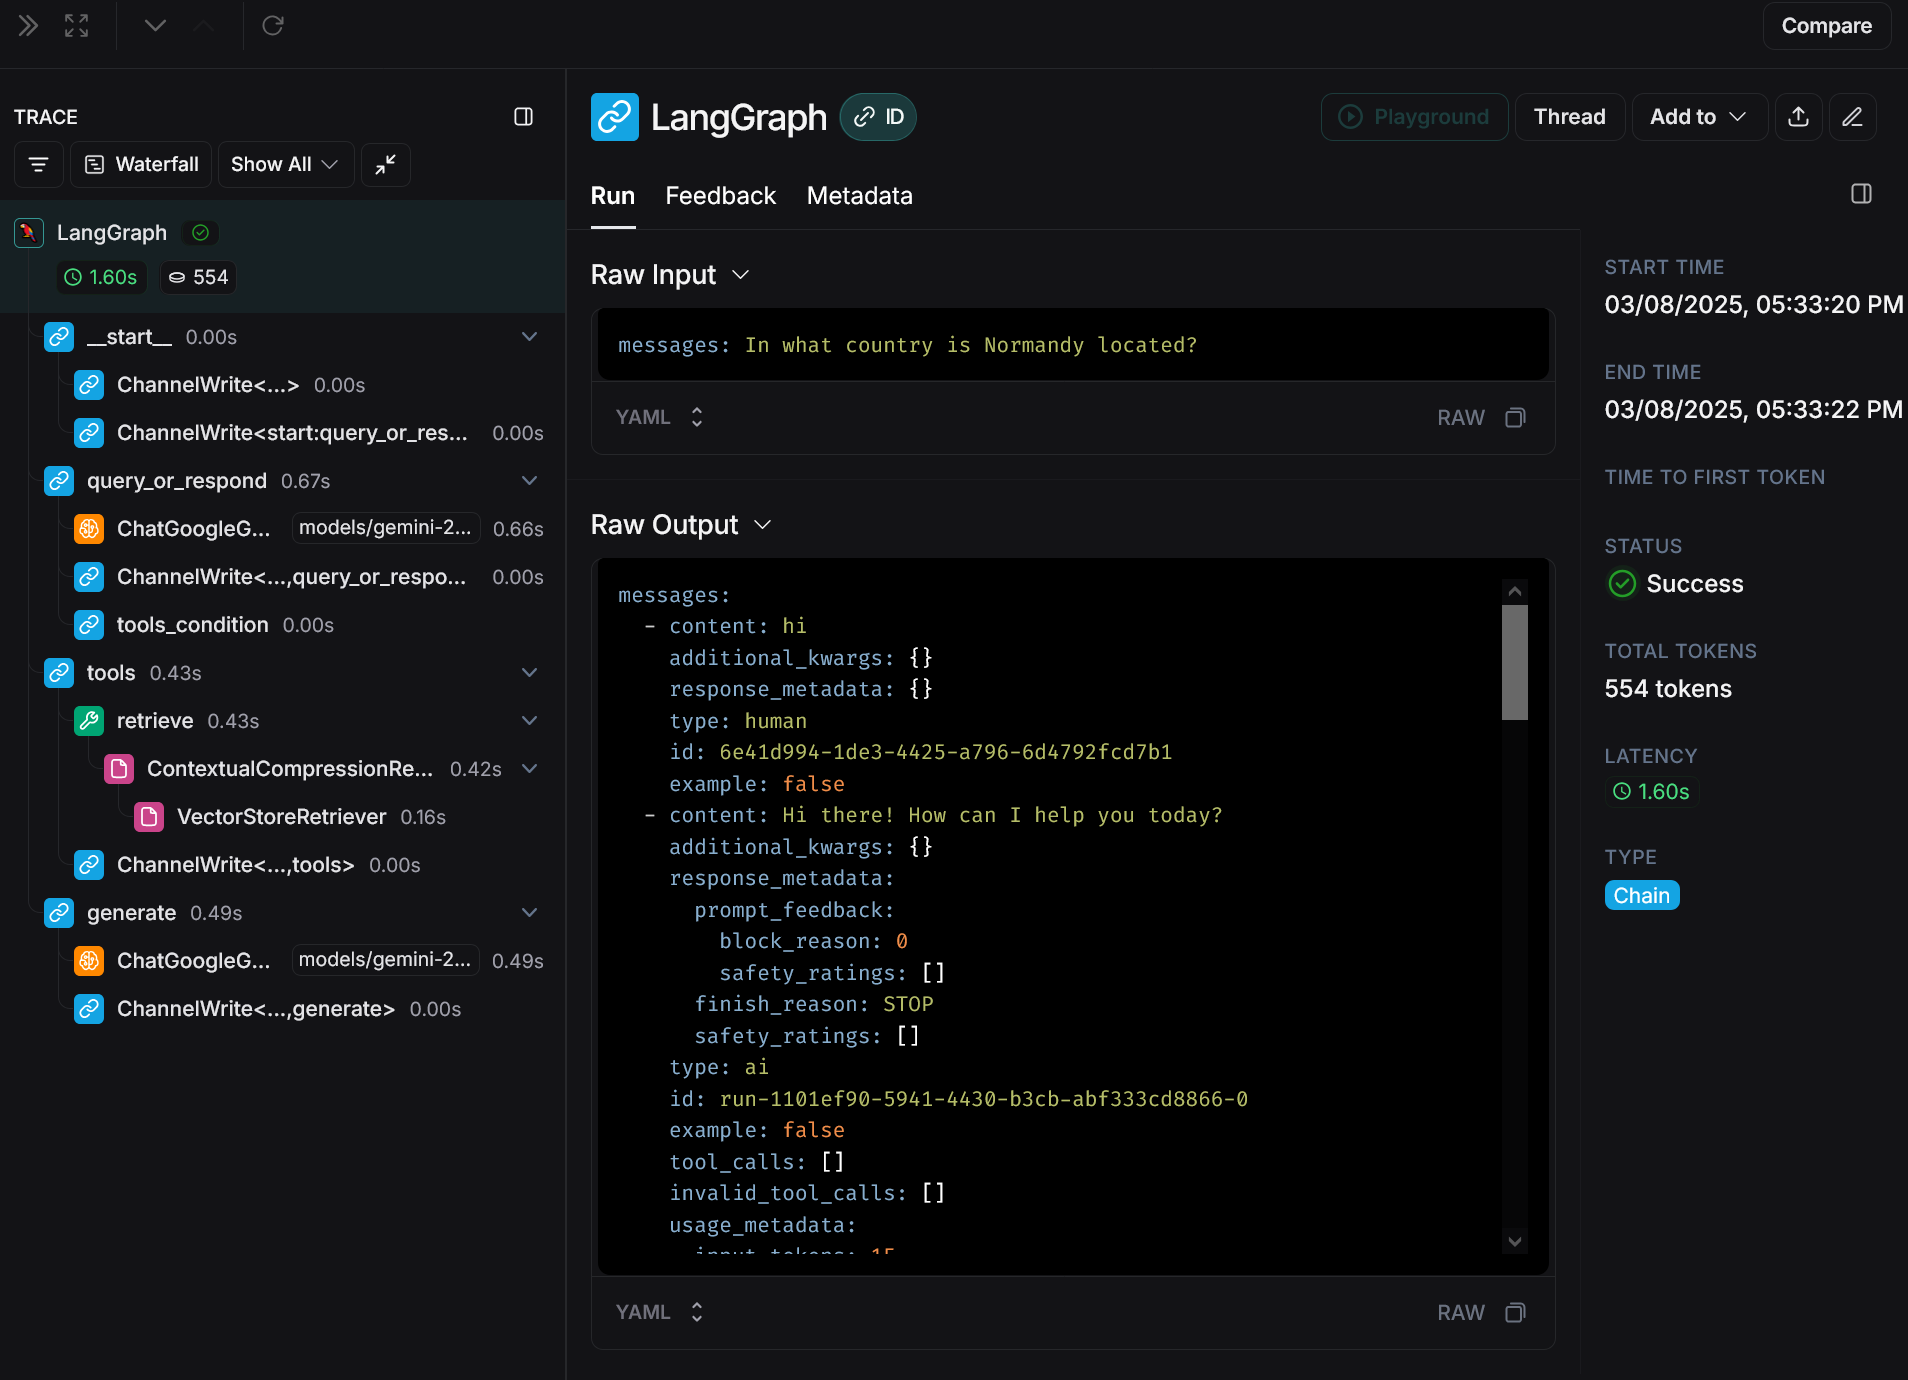

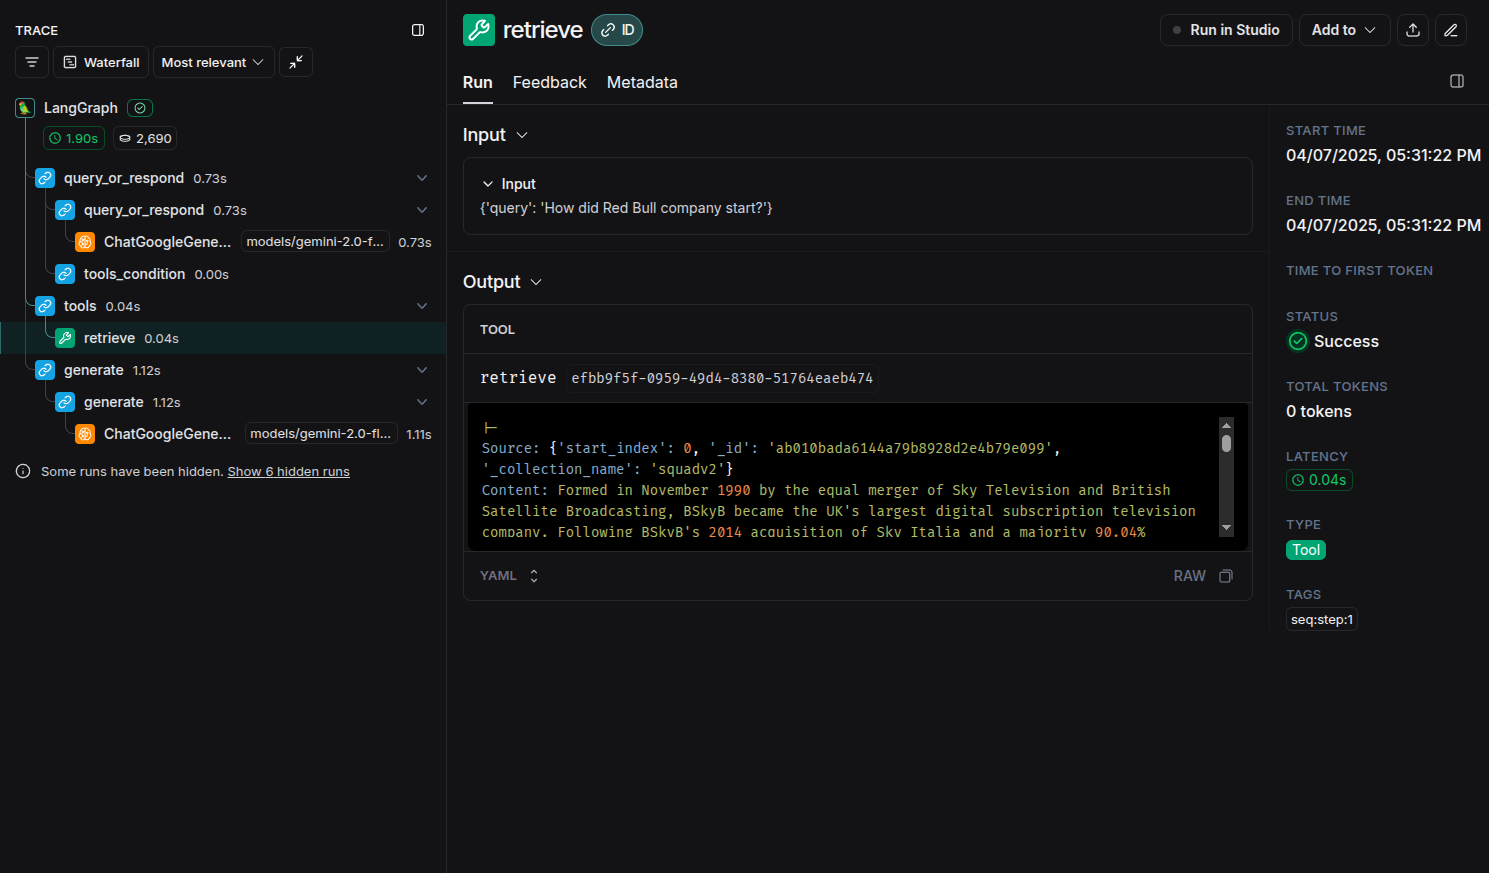
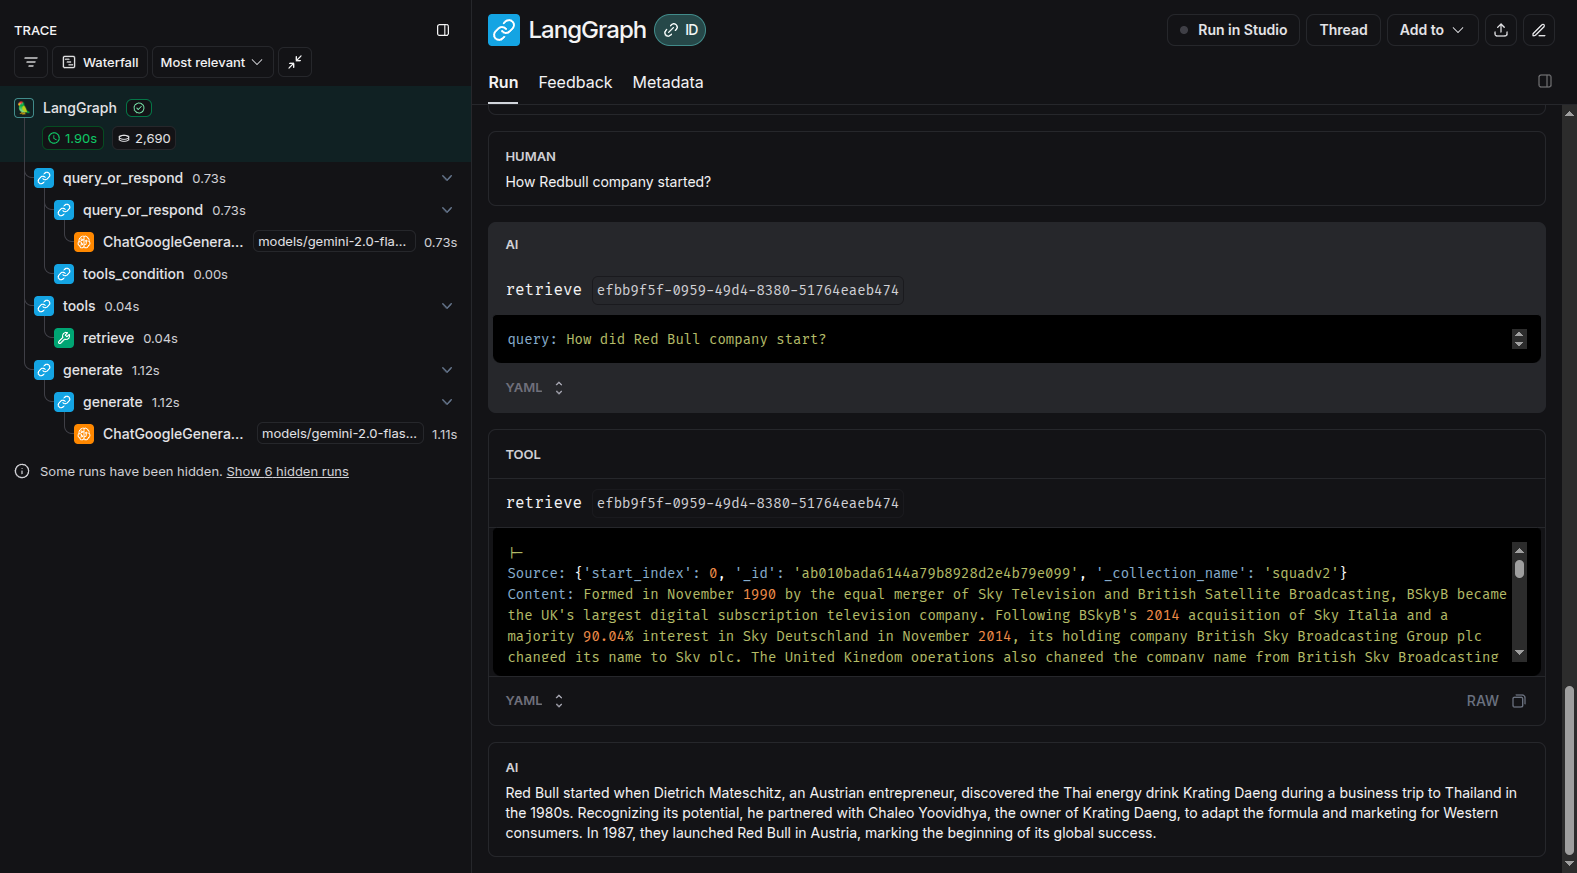